In [1]:
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')

Inorder to get the data from AWS postgres server we can use this command to connect to the server:
>psql -h dsi.c20gkj5cvu3l.us-east-1.rds.amazonaws.com -p 5432 -U dsi_student titanic

psql will ask for password and after we provide it we can use following command to select everything from database table and export it to csv file:
>\COPY (select * from train) to '~/Downloads/train.csv' DELIMITER ',' csv header;

Now that we have our csv file we can move it to an appropriate directory and read it through pandas as usual

In [2]:
titanic_data = pd.read_csv('train.csv')

titanic_data.head(3)

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
test_df = pd.read_csv('test.csv')

In [4]:
test_df.describe()

/home/ali/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,NaN,0.000000,0.000000,NaN
50%,1100.500000,3.000000,NaN,0.000000,0.000000,NaN
75%,1204.750000,3.000000,NaN,1.000000,0.000000,NaN
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [5]:
titanic_data.describe()

,index,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,445.000000,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,222.500000,223.500000,0.000000,2.000000,NaN,0.000000,0.000000,7.910400
50%,445.000000,446.000000,0.000000,3.000000,NaN,0.000000,0.000000,14.454200
75%,667.500000,668.500000,1.000000,3.000000,NaN,1.000000,0.000000,31.000000
max,890.000000,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
df = titanic_data.copy() # create a copy of data so original dosn't get modified
df.count()

index          891
PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

As we can see not all data is available and we have multiple values missing from `Age`, `Cabin` and `Embarked` columns. I think removing data rows will have negative effect on our classification since we dont know how the real data would look like.

Next step would be feature selection. There are some feature that seem to have effect on survival rate based on survival stories. One of them is gender. As our observation first we are going to show survival rate based on gender.

In [7]:
test_df = test_df.reset_index()
test_df

,index,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


In [8]:
sex_survive = pd.pivot_table(df, index='Sex', values=['index','Survived'], aggfunc=[np.count_nonzero])
# sex_survive.columns=['Survived', 'Total']
sex_survive


count_nonzero      
            Survived index
Sex                       
female           233   314
male             109   576

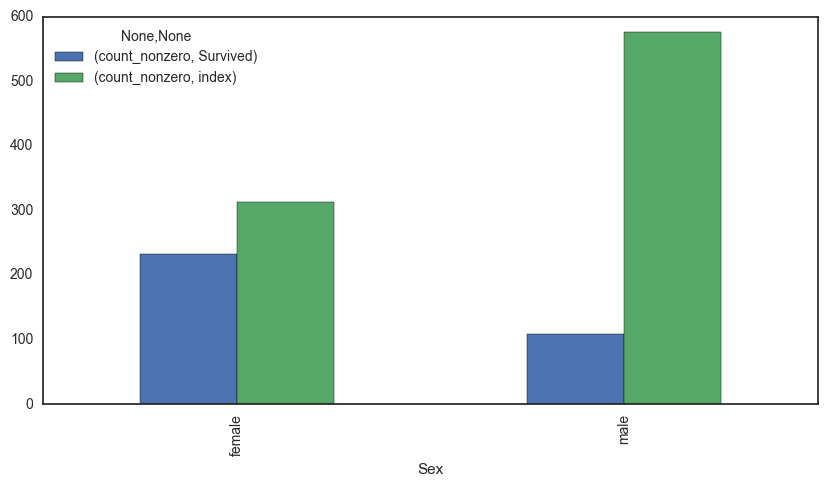

In [9]:
sex_survive.plot(kind='bar', figsize=(10,5))

We can see females had better chanse of survival.

We can also take age to account as a feature. I decided to categorize age so it would be easier to categorize results.

In [10]:
#Binning:
def binning(col, cut_points, labels=None):
    #Define min and max values:
    minval = col.min()
    maxval = col.max()

    #create list by adding min and max to cut_points
    break_points = [minval] + cut_points + [maxval]

    #if no labels provided, use default labels 0 ... (n-1)
    if not labels:
        labels = range(len(cut_points)+1)

    #Binning using cut function of pandas
    colBin = pd.cut(col,bins=break_points,labels=labels,include_lowest=True)
    return colBin

In [11]:
#Binning age:
cut_points = [12, 40, 50, 199]
labels = ['children', 'young', 'middle_age', 'older', 'no_age']
df["Age_bin"] = binning(df["Age"].fillna(200), cut_points, labels)
test_df["Age_bin"] = binning(df["Age"].fillna(200), cut_points, labels)

In [12]:
age_survive = pd.pivot_table(df, index='Age_bin', values=['index','Survived'], aggfunc=[np.count_nonzero])
age_survive.columns=['Survived', 'Total']
age_survive

,Survived,Total
Age_bin,,
children,40,69
young,195,494
middle_age,33,86
older,22,64
no_age,52,177


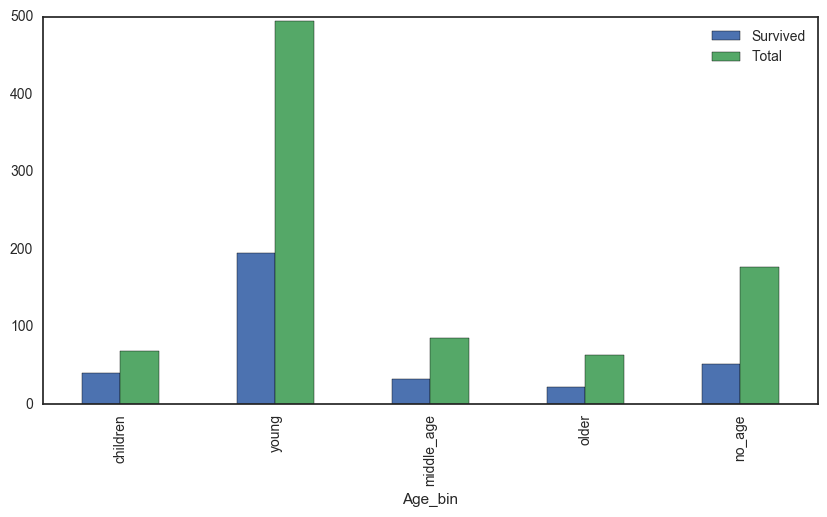

In [13]:
age_survive.plot(kind='bar', figsize=(10,5))

As we can see children had better chance of survival.

Class also may have effect on survival rate.

In [14]:
class_survive = pd.pivot_table(df, index='Pclass', values=['index','Survived'], aggfunc=[np.count_nonzero])
class_survive.columns=['Survived', 'Total']
class_survive

,Survived,Total
Pclass,,
1,136,216
2,87,184
3,119,490


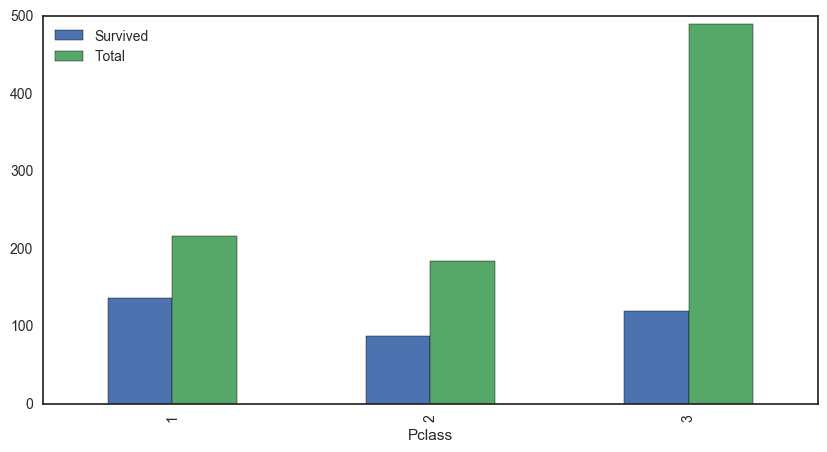

In [15]:
class_survive.plot(kind='bar', figsize=(10,5))

As we can see first class passengers had better chance of survival

Location of the decks could also have effect on survival rate

In [16]:
df['Deck'] = titanic_data.Cabin.fillna('0').apply(lambda x: x[0] if x!='0' else None).to_frame()
test_df['Deck'] = titanic_data.Cabin.fillna('0').apply(lambda x: x[0] if x!='0' else None).to_frame()
class_survive = pd.pivot_table(df, index='Deck', values=['index','Survived'], aggfunc=[np.count_nonzero])
class_survive.columns=['Survived', 'Total']
class_survive

,Survived,Total
Deck,,
A,7,15
B,35,47
C,35,59
D,25,33
E,24,32
F,8,13
G,2,4
T,0,1


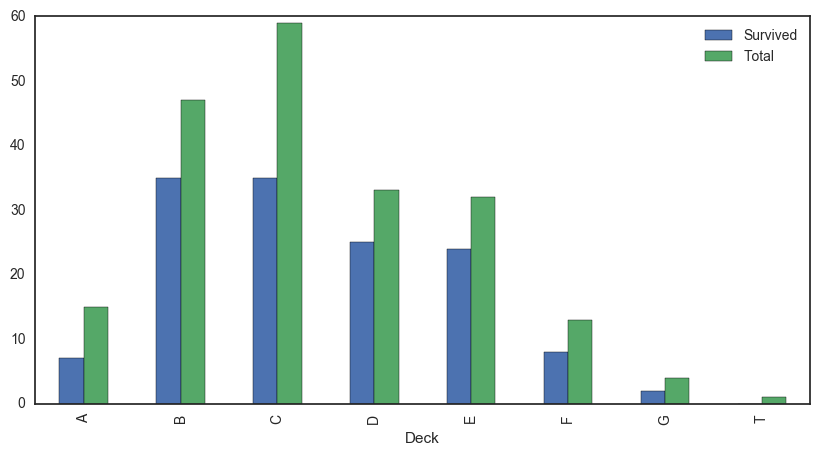

In [17]:
class_survive.plot(kind='bar', figsize=(10,5))

Although it seems deck can have a significant survival effect but since there are lots of data missing in `Cabin` column we cannot get a good feature.

Now that we have some clue of features we can use in our prediction I decided to use RFE and Kbest feature selectors to find the best selectors. Therefore I'm just going to dummify and extract feature and through them in feature selectors to find the best results

In [18]:
decks = pd.get_dummies(df.Deck)
decks_test = pd.get_dummies(test_df.Deck)

In [19]:
df.Sex = df.Sex.apply(lambda x: 1 if x=='female' else 0)
test_df.Sex = test_df.Sex.apply(lambda x: 1 if x=='female' else 0)
df.head(3)

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_bin,Deck
0,0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,young,None
1,1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,young,C
2,2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,young,None


In [20]:
age_bins = pd.get_dummies(df.Age_bin, prefix='Age_bin')
age_bins_test = pd.get_dummies(test_df.Age_bin, prefix='Age_bin')
age_bins.head(3)

,Age_bin_children,Age_bin_young,Age_bin_middle_age,Age_bin_older,Age_bin_no_age
0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0


In [21]:
pclasses = pd.get_dummies(df.Pclass, prefix='Pclass')
pclasses_test = pd.get_dummies(test_df.Pclass, prefix='Pclass')
pclasses.head(3)

,Pclass_1,Pclass_2,Pclass_3
0,0.0,0.0,1.0
1,1.0,0.0,0.0
2,0.0,0.0,1.0


In [22]:
embarked = pd.get_dummies(df.Embarked, prefix='Embarked')
embarked_test = pd.get_dummies(test_df.Embarked, prefix='Embarked')

embarked.head(3)

,Embarked_C,Embarked_Q,Embarked_S
0,0.0,0.0,1.0
1,1.0,0.0,0.0
2,0.0,0.0,1.0


Krew of Titanc were also passenger so we can use it as a feature.

In [23]:
workers = df.Ticket.apply(lambda x: 1 if x=='LINE' else 0).to_frame()
workers_test = test_df.Ticket.apply(lambda x: 1 if x=='LINE' else 0).to_frame()

workers.columns = ['Worker']
workers_test.columns = ['Worker']

We can also find out which passenger was sengle or with family and use this information as a feature

In [24]:
singles = df.apply(lambda x: 1 if (x['SibSp']==0 & x['Parch']==0) else 0, axis=1).to_frame()
singles_test = test_df.apply(lambda x: 1 if (x['SibSp']==0 & x['Parch']==0) else 0, axis=1).to_frame()

singles.columns = ['Single']
singles_test.columns = ['Single']

with_family = df.apply(lambda x: 1 if (x['SibSp']==1 or x['Parch']==1) else 0, axis=1).to_frame()
with_family_test = test_df.apply(lambda x: 1 if (x['SibSp']==1 or x['Parch']==1) else 0, axis=1).to_frame()

with_family.columns = ['WithFamily']
with_family_test.columns = ['WithFamily']

In [25]:
def combine_features(X, feature_list):
    for feat in feature_list:
        X = X.join(feat, how="left")
    return X

In [26]:
X=df['Sex'].to_frame()
y=df['Survived']
feature_list = [singles, decks, pclasses, age_bins, with_family, embarked, workers]
kbest_selector = SelectKBest(k=5)
all_features = combine_features(X, feature_list)
feature_count = np.count_nonzero(all_features.columns)

test_X=df['Sex'].to_frame()
test_y=df['Survived']
feature_list_test = [singles_test, decks_test, pclasses_test, age_bins_test, with_family_test, embarked_test, workers_test]
test_kbest_selector = SelectKBest(k=5)
test_all_features = combine_features(X, feature_list_test)
test_feature_count = np.count_nonzero(test_all_features.columns)

# KNN

First I'm going to use KNN as a classifier

In [27]:
def knn_score(X, y, n=5):
    knn = KNeighborsClassifier(n_neighbors=n)
    SS = StandardScaler()
    knn.fit(SS.fit_transform(X), y)
    return knn.score(SS.fit_transform(X), y)

def best_knn_k(X,y,max_features, n=5):
    max_score = 0
    best_k = 0
    for i in range(max_features):
        kbest = SelectKBest(k=i+1)
        score = knn_score(kbest.fit_transform(X, y), y, n=n)
        if score > max_score:
            max_score = score
            best_k = i+1
    return best_k

In [28]:
good_features = kbest_selector.fit_transform(all_features, y)

In [29]:
knn = KNeighborsClassifier(n_neighbors=5)
knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [30]:
SS = StandardScaler()
knn.fit(SS.fit_transform(good_features), y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [31]:
knn.score(SS.fit_transform(good_features), y)

0.78563411896745228

Use kbest selector to select 18 (a random number) good features and compare the results

In [32]:
kbest_selector.k = 18
good_features = kbest_selector.fit_transform(all_features, y)
knn_score(good_features, y, n=5)

0.82491582491582494

As we can see results change. Now I'll try useing kbest feature selector to find the best number of features

In [33]:
k = best_knn_k(all_features, y, feature_count)
kbest_selector.k=k
good_features = kbest_selector.fit_transform(all_features, y)
print k
print knn_score(good_features, y, n=5)

11
0.835016835017


Based on all our features if we use 11 of our best features we can have the best results with KNN

Now I'm going to use grid search to optimize my models parameters

In [34]:
model = KNeighborsClassifier()
n_neighbors = [1, 3, 5, 7, 9]
weights = ['uniform', 'distance']
algorithm=['auto', 'ball_tree', 'kd_tree', 'brute']
Ps = [1, 2]
grid = GridSearchCV(estimator=model, 
                    param_grid={'n_neighbors': n_neighbors,
                                'weights': weights,
                                'algorithm':algorithm,
                                'p': Ps
                               },
                    cv = 6
                   )

In [35]:
SS = StandardScaler()
grid.fit(SS.fit_transform(good_features),y)
best_knn_model = grid.best_estimator_
print best_knn_model
print grid.best_score_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
0.811447811448


We can see from above that grid search selected different options for our model which reduces over-fitting

Now I'm going to use cross validation to see if my model produces the best results

In [36]:
x_train, x_test, y_train, y_test = train_test_split(all_features, y)

In [37]:
train_knn = kbest_selector.fit_transform(x_train, y_train)
SS = StandardScaler()
best_knn_model.fit(SS.fit_transform(train_knn),y_train)
print best_knn_model.score(SS.fit_transform(train_knn),y_train)

0.817365269461


In [38]:
test_knn = kbest_selector.fit_transform(x_test, y_test)
SS = StandardScaler()
best_knn_model.fit(SS.fit_transform(test_knn),y_test)
print best_knn_model.score(SS.fit_transform(test_knn),y_test)

0.789237668161


/home/ali/anaconda2/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [8 9] are constant.
  UserWarning)


As we can see our model was able to categorize the test data with 2% error which is decent.

We can see confusion matrix, Precision/Recall matrix and its heatmap as follow:

Confusion matrix: 
[[489  60]
 [ 87 255]]

Precision Recall:
             precision    recall  f1-score   support

          0       0.85      0.89      0.87       549
          1       0.81      0.75      0.78       342

avg / total       0.83      0.84      0.83       891



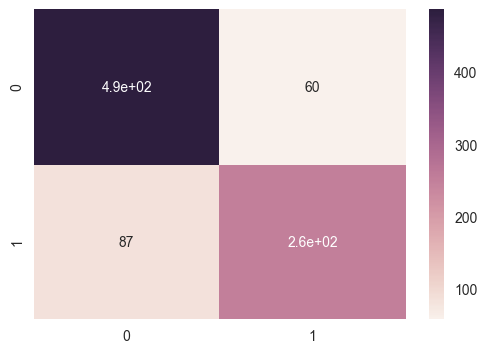

In [39]:
# good_features = kbest_selector.fit_transform(all_features, y)
SS = StandardScaler()
best_knn_model.fit(SS.fit_transform(good_features),y)
predictions = best_knn_model.predict(SS.fit_transform(good_features))
print "Confusion matrix: \n", confusion_matrix(y, predictions)
print "\nPrecision Recall:\n", classification_report(y, predictions)
sns.heatmap(confusion_matrix(y, predictions), annot=True)

We can also plot ROC curve of our model

(array([ 0.        ,  0.10928962,  1.        ]), array([ 0.        ,  0.74561404,  1.        ]), array([2, 1, 0]))


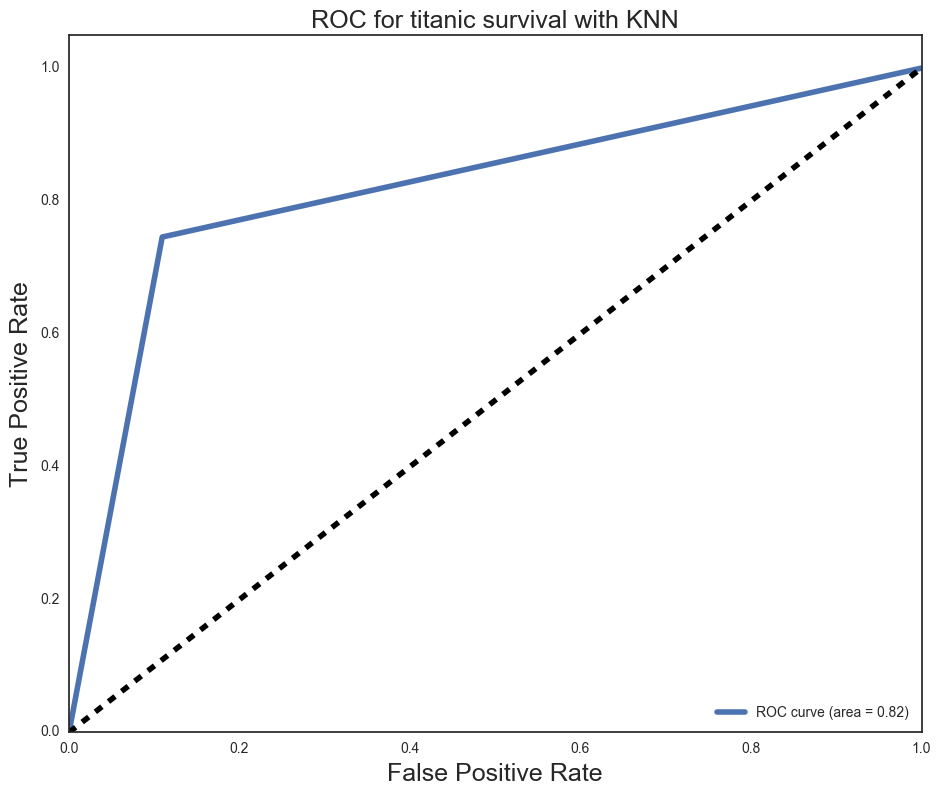

In [40]:
y_pred = grid.best_estimator_.predict(SS.fit_transform(good_features))
FPR = dict()
TPR = dict()
ROC_AUC = dict()
print roc_curve(y, y_pred)
FPR[1], TPR[1], _ = roc_curve(y, y_pred)
ROC_AUC[1] = auc(FPR[1], TPR[1])
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC for titanic survival with KNN', fontsize=18)
plt.legend(loc="lower right")
plt.show()

# Logistic Regression

Now I'm going to use Logistic Regression as categorizer. This time I'm going to use both Kbest and RFE to find the best features

In [41]:
def best_log_rfe_k(X,y,model, max_features, n=5):
    max_score = 0
    best_k = 0
    for i in range(max_features):
        rfe = RFE(estimator=model, step=1, n_features_to_select=i+1)
        model.fit(rfe.fit_transform(X, y), y)
        score = model.score(rfe.fit_transform(X, y), y)
        
        if score > max_score:
            max_score = score
            best_k = i+1
    return best_k

In [42]:
def best_log_kbest_k(X,y,model,max_features, n=5):
    max_score = 0
    best_k = 0
    for i in range(max_features):
        kbest = SelectKBest(k=i+1)
        model.fit(kbest.fit_transform(X, y), y)
        score = model.score(kbest.fit_transform(X, y), y)
        if score > max_score:
            max_score = score
            best_k = i+1
    return best_k

## RFE

In [43]:
model = LogisticRegression()
rfe_k = best_log_rfe_k(all_features, y, model, feature_count)
print "best number of features in RFE feature selector: ", rfe_k
rfe_log_selector = RFE(estimator=model, step=1, n_features_to_select=rfe_k)
best_rfe_features = rfe_log_selector.fit_transform(all_features, y)
model.fit(best_rfe_features, y)
print model.score(rfe_log_selector.fit_transform(all_features, y), y)

best number of features in RFE feature selector:  13
0.821548821549


As we can see `13` is the best number of features and RFE selects them for us

Now we try to improve our selector

We can have different parametrs in our model:

In [44]:
model = LogisticRegression(penalty='l1', C=0.1)
print model.fit(best_rfe_features,y)
print model.coef_
print model.score(best_rfe_features,y)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
[[ 2.102977    0.          0.          0.          0.          0.
   0.09778195 -1.26712213  0.22105529  0.          0.         -0.54402262
   0.        ]]
0.786756453423


In [45]:
model = LogisticRegression(penalty='l1', C=1)
print model.fit(best_rfe_features,y)
print model.coef_
print model.score(best_rfe_features,y)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
[[ 2.54574595  0.1451142   0.41963046  0.78665002  1.22941548  0.55431385
   0.55051926 -1.27127007  1.17101855 -0.41109775 -0.79984474 -0.60809201
   0.        ]]
0.820426487093


In [46]:
model = LogisticRegression(penalty='l2', C=1)
print model.fit(best_rfe_features,y)
print model.coef_
print model.score(best_rfe_features,y)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
[[ 2.50621637  0.16808942  0.50201422  0.83570544  1.19886723  0.71769772
   0.58299212 -1.23235958  1.15487788 -0.45699947 -0.83666903 -0.60311607
   0.5261868 ]]
0.821548821549


LogisticRegression(C=0.03, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.811447811448

Confusion Matrix:
[[523  26]
 [142 200]]

Precision Recall:
             precision    recall  f1-score   support

          0       0.79      0.95      0.86       549
          1       0.88      0.58      0.70       342

avg / total       0.82      0.81      0.80       891



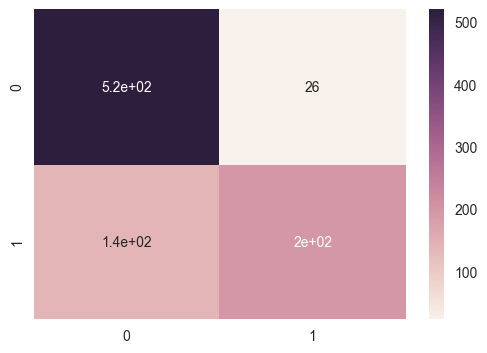

In [47]:
model = LogisticRegression()
Cs = [.01, .03, .05, 0.7, .09, .1, .3, .5, .7, 1, 10, 50, 100]
Ls = ['l1', 'l2']
rfe_grid = GridSearchCV(estimator=model, 
                    param_grid={'C': Cs,
                                'penalty': Ls
                               },
                    cv = 6
                   )
rfe_grid.fit(best_rfe_features,y)
print rfe_grid.best_estimator_
print rfe_grid.best_score_
log_model_rfe = rfe_grid.best_estimator_
predictions = log_model_rfe.predict(best_rfe_features)
print "\nConfusion Matrix:\n", confusion_matrix(y, predictions)
print "\nPrecision Recall:\n", classification_report(y, predictions)
sns.heatmap(confusion_matrix(y, predictions), annot=True)

Now we are going to cross validate to determine wether our model over-fits or not

In [48]:
test_df = pd.read_csv('test.csv')

In [49]:
test_df.Sex = test_df.Sex.apply(lambda x: 1 if x=='female' else 0)

In [50]:
feature_list_test = [singles_test, decks_test, pclasses_test, age_bins_test, with_family_test, embarked_test, workers_test]

In [51]:
def combine(X, feature_list):
    for feat in feature_list:
        X = X.join(feat, how="left")
    return X

In [52]:
kaggle_rfe = rfe_log_selector.transform(test_all_features)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
kaggle_results = rfe_log_selector.predict(test_all_features)
kaggle_results

In [ ]:
kaggle = pd.DataFrame(kaggle_results)
kaggle=test_df.join(kaggle)
kaggle = kaggle[['PassengerId', 0]]
kaggle.columns = ['PassengerId', 'Survived']
kaggle.to_csv('kaggl_results.csv', index=False)

In [ ]:
from sklearn.cross_validation import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

In [ ]:
decision_tree = DecisionTreeClassifier()
cv_dt=cross_val_score(decision_tree, best_rfe_features, y, cv=5)
cv_dt

In [ ]:
print 'Decision Tree mean accuracy %s' % (np.mean(cv_dt))

In [ ]:
bagging_classifier = BaggingClassifier(decision_tree)
cv_bg = cross_val_score(bagging_classifier, best_rfe_features,y, cv=5)
cv_bg

In [ ]:
print 'Bagging Classifier mean accuracy %s' % (np.mean(cv_bg))

In [ ]:
bagging_classifier.fit(best_rfe_features,y)

In [ ]:
bagging_classifier.predict(test_all_features)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(all_features, y)
x_train.shape, x_test.shape

In [ ]:
train_rfe = rfe_log_selector.fit_transform(x_train, y_train)
print train_rfe.shape
train_rfe

In [ ]:
log_model_rfe.fit(train_rfe, y_train)
print 'Score with training data (rfe):', log_model_rfe.score(train_rfe, y_train)

In [ ]:
test_rfe = rfe_log_selector.transform(x_test)
print 'Score with TEST data (rfe):', log_model_rfe.score(test_rfe, y_test)

In [ ]:
kaggle_rfe = rfe_log_selector.transform(test_all_features.dropna())

In [ ]:
kaggle_results = rfe_log_selector.predict(test_all_features.dropna())
kaggle_results

In [ ]:
kaggle = pd.DataFrame(kaggle_results)
kaggle=test_df.join(kaggle)
kaggle = kaggle[['PassengerId', 0]]
kaggle.columns = ['PassengerId', 'Survived']
kaggle.to_csv('kaggl_results_RFE.csv', index=False)

In [ ]:
# kaggle_results = best_knn_model.predict(test_all_features)
# kaggle_results

In [ ]:
# kaggle = pd.DataFrame(kaggle_results)
# kaggle=test_df.join(kaggle)
# kaggle = kaggle[['PassengerId', 0]]
# kaggle.columns = ['PassengerId', 'Survived']
# kaggle.to_csv('kaggl_results.csv', index=False)

In [ ]:
len(kaggle_results)

In [ ]:
log_model_rfe.fit(x_train, y_train)
print 'Score with training data (all):', log_model_rfe.score(x_train, y_train)

In [ ]:
print 'With all of our columns! We get:', log_model_rfe.score(x_test, y_test)

This shows our model has low over-fitting

In [ ]:
scores = rfe_log_selector.ranking_

predictors = all_features.columns

print scores
print rfe_log_selector.support_
for item in zip(predictors, scores, rfe_log_selector.support_):
    print item


# # Plot the scores.  See how "Pclass", "Sex", "Title", and "Fare" are the best?
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()


In [ ]:
y_pred = log_model_rfe.decision_function(x_test)
FPR = dict()
TPR = dict()
ROC_AUC = dict()
print roc_curve(y_test, y_pred)
FPR[1], TPR[1], _ = roc_curve(y_test, y_pred)
ROC_AUC[1] = auc(FPR[1], TPR[1])
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC for titanic survival with RFE', fontsize=18)
plt.legend(loc="lower right")
plt.show()

## Kbest

Now we are going to do the same for Kbest feature selector

In [ ]:
def best_log_kbest_k(X,y,model,max_features, n=5):
    max_score = 0
    best_k = 0
    for i in range(max_features):
        kbest = SelectKBest(k=i+1)
        model.fit(kbest.fit_transform(X, y), y)
        score = model.score(kbest.fit_transform(X, y), y)
        if score > max_score:
            max_score = score
            best_k = i+1
    return best_k

In [ ]:
kbest_log_model = LogisticRegression()
kbest_k = best_log_kbest_k(all_features, y, kbest_log_model, feature_count)
print "best number of features in Kbest feature selector: ", kbest_k
kbest_log_selector = SelectKBest(k=kbest_k)
best_kbest_features = kbest_log_selector.fit_transform(all_features, y)
kbest_log_model.fit(best_kbest_features, y)
print kbest_log_model.score(kbest_log_selector.fit_transform(all_features, y), y)

For Kbest in this model it is better to use `23` features which is all of our features

Since we are using all 23 features results will be the same as all_features and because of that I'm going to use 18 as K so our resuls may vary and compare it to all_features

In [ ]:
kbest_log_selector = SelectKBest(k=18)
best_kbest_features = kbest_log_selector.fit_transform(all_features, y)
kbest_log_model.fit(best_kbest_features, y)
print kbest_log_model.score(kbest_log_selector.fit_transform(all_features, y), y)

In [ ]:
model = LogisticRegression(penalty='l1', C=0.1)
print model.fit(best_kbest_features,y)
print model.coef_
print model.score(best_kbest_features,y)

In [ ]:
model = LogisticRegression(penalty='l1', C=10)
print model.fit(best_kbest_features,y)
print model.coef_
print model.score(best_kbest_features,y)

So to tweak things further i'm going to use grid search to find the best parameters

In [ ]:
model = LogisticRegression()
Cs = [.01, .03, .05, 0.7, .09, .1, .3, .5, .7, 1, 10, 50, 100]
Ls = ['l1', 'l2']
kbes_grid = GridSearchCV(estimator=model, 
                    param_grid={'C': Cs,
                                'penalty': Ls
                               },
                    cv = 6
                   )
kbes_grid.fit(best_kbest_features,y)
print kbes_grid.best_estimator_
print kbes_grid.best_score_
log_model_kbest = kbes_grid.best_estimator_
predictions = log_model_kbest.predict(best_kbest_features)
print "\nConfusion Matrix:\n", confusion_matrix(y, predictions)
print "\nPrecision Recall:\n", classification_report(y, predictions)
sns.heatmap(confusion_matrix(y, predictions), annot=True)

To crossvalidate again I'm going to split data set to test and train

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(all_features, y)
x_train.shape, x_test.shape

In [ ]:
train_kbest = kbest_log_selector.fit_transform(x_train, y_train)
print train_kbest.shape
train_kbest

In [ ]:
log_model_kbest.fit(train_kbest, y_train)
print 'Score with training data (kbest):', log_model_kbest.score(train_kbest, y_train)

In [ ]:
test_kbest = kbest_log_selector.fit_transform(x_test, y_test)
print 'Score with TEST data (kbest):', log_model_kbest.score(test_kbest, y_test)

In [ ]:
log_model_kbest.fit(x_train, y_train)
print 'Score with training data (all):', log_model_kbest.score(x_train, y_train)

In [ ]:
print 'With all of our columns! We get:', log_model_kbest.score(x_test, y_test)

As we can see we have more over-fitting than RFE

In [ ]:
scores = -np.log10(kbest_log_selector.pvalues_)
print scores
print kbest_log_selector.pvalues_

predictors = all_features.columns

# # Plot the scores.  See how "Pclass", "Sex", "Title", and "Fare" are the best?
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()


In [ ]:
y_pred = log_model_kbest.decision_function(x_test)

FPR = dict()
TPR = dict()
ROC_AUC = dict()

print roc_curve(y_test, y_pred)

FPR[1], TPR[1], _ = roc_curve(y_test, y_pred)
ROC_AUC[1] = auc(FPR[1], TPR[1])


plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for cancer detection', fontsize=18)
plt.legend(loc="lower right")
plt.show()
